## 0)import libraries 

In [1]:
"""
Thesis_PhD_Qianqian Predicted_fluxes_glboal_stripes
date: 24-Feb-2023
author: Qianqian
Contact: q.han@utwente.nl
-------------------------------------
Description: 
"""
# libraries
import os
import joblib
from osgeo import gdal
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from rasterio.warp import reproject, Resampling
import xarray as xr
import pickle
from PyStemmusScope import variable_conversion as vc
from rasterio.warp import reproject, Resampling
from sklearn.preprocessing import OneHotEncoder
import time
import re
import glob
import rioxarray
import dask.array
from dask.distributed import Client, progress

## 1)settings for Dask

In [2]:
# Set the MALLOC_TRIM_THRESHOLD_ environment variable
os.environ['MALLOC_TRIM_THRESHOLD_'] = '0'

# Run your Dask script or notebook
...

Ellipsis

In [3]:
client = Client(n_workers=4, threads_per_worker=2)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 8,Total memory: 240.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43487,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 8
Started: Just now,Total memory: 240.00 GiB
Comm: tcp://127.0.0.1:42241,Total threads: 2
Dashboard: /proxy/38491/status,Memory: 60.00 GiB
Nanny: tcp://127.0.0.1:32791,


## 2)define working path, load trained model, define functions

In [4]:
workingPath = "/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/"

In [5]:
# load trained RF model, better use not parallel model with Dask
with open(workingPath+'3RF_train/RFLEH-LAI-hc-CO2-SSM-Vcmo-IGBP_multi7_1core_snellius0629.pkl', 'rb') as f:
    rfLEHmulti = pickle.load(f)

In [6]:
# function for loading the trained model
def load_model(path):
    # load trained RF model, better use not parallel model with Dask
    with open(path, 'rb') as f:
        rfLEHmulti = pickle.load(f)
    return rfLEHmulti

In [7]:
# function for getting directory of input data
def get_directories_with_number_and_ending(directory_path, ending):
    directories = []
    if ending:
        pattern = re.compile(r'^\d+.*{}$'.format(re.escape(ending)))  # Match directory names with number at the beginning and specific ending
    else:
        pattern = re.compile(r'^\d+$')  # Match directory names with only numbers

    for entry in os.scandir(directory_path):
        if entry.is_dir():
            directory_name = entry.name
            if pattern.match(directory_name):
                directories.append(directory_name)

    return directories

## 3) read data

In [8]:
### define the path of input data, set the reference file for spatial resample
inputData = workingPath+"1input_data/"
# get all the filefolders named as year
year_list = get_directories_with_number_and_ending(workingPath+"1input_data/", "global")
# the input data from year[0] to year[..], based on the process id in sbatch script
year = year_list[4-1]
print(year)
# reference file for spatial resample
era5 = xr.open_dataset(inputData+"/2015global/era5land/era5-land_10m_u_component_of_wind_2015-01.nc")#.sel(latitude=slice(55, 45), longitude=slice(2, 12))#.sel(time=t, method='nearest')['u10']

2015global


In [9]:
lon_name = 'longitude'
era5['longitude_adjusted'] = xr.where(
    era5[lon_name] > 180,
    era5[lon_name] - 360,
    era5[lon_name])
era5 = (
    era5
    .swap_dims({lon_name: 'longitude_adjusted'})
    .sel(**{'longitude_adjusted': sorted(era5.longitude_adjusted)})
    .drop(lon_name))
era5 = era5.rename({'longitude_adjusted': lon_name})

In [10]:
import geopandas as gpd
from shapely.geometry import box

shapefile_path = "/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/Emulator/EuropeBoundary.shp"
gdf = gpd.read_file(shapefile_path)
bbox = gdf.total_bounds
bbox

array([-31.28903052,  34.93055094,  68.93136141,  81.85192337])

In [11]:
lat1 = 40
lat2 = 55
lon1 = 2
lon2 = 17

In [12]:
# 使用 sel 函数来裁剪 DataArray
era5 = era5.sel(
    latitude=slice(lat2,lat1),  # 根据南北边界裁剪
    longitude=slice(lon1, lon2)  # 根据西东边界裁剪
)

In [13]:
era5

<xarray.Dataset>
Dimensions:    (latitude: 151, time: 744, longitude: 151)
Coordinates:
  * latitude   (latitude) float32 55.0 54.9 54.8 54.7 ... 40.3 40.2 40.1 40.0
  * time       (time) datetime64[ns] 2015-01-01 ... 2015-01-31T23:00:00
  * longitude  (longitude) float32 2.0 2.1 2.2 2.3 2.4 ... 16.7 16.8 16.9 17.0
Data variables:
    u10        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-06-19 15:57:25 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [14]:
# ### 0) read era5land data
## select Europe data of ERA5Land and save it as netcdf
# all1 = xr.open_mfdataset(inputData+year+"/era5land/era5-land*.nc", chunks='auto')
# lon_name = 'longitude'
# all1['longitude_adjusted'] = xr.where(
#     all1[lon_name] > 180,
#     all1[lon_name] - 360,
#     all1[lon_name])
# all1 = (
#     all1
#     .swap_dims({lon_name: 'longitude_adjusted'})
#     .sel(**{'longitude_adjusted': sorted(all1.longitude_adjusted)})
#     .drop(lon_name))
# all1 = all1.rename({'longitude_adjusted': lon_name})
# all1 = all1.sel(
#     latitude=slice(bbox[3], bbox[1]),  # 根据南北边界裁剪
#     longitude=slice(bbox[0], bbox[2])  # 根据西东边界裁剪
# )
# all1.to_netcdf('/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/1input_data/2015global/era5land/era5land2015_10km1.nc',format='NETCDF4')

In [15]:
all1 = xr.open_mfdataset(inputData+year+"/era5land/era5land2015_10km1.nc", chunks='auto')

In [16]:
all1 = all1.sel(
    latitude=slice(lat2,lat1),  # 根据南北边界裁剪
    longitude=slice(lon1, lon2)  # 根据西东边界裁剪
)

In [17]:
all_resample = all1.resample(time="1800S").interpolate('linear')
all_resample = all_resample.isel(time=slice(0,17000))

In [18]:
%%time
# calculate the Rin and Rli difference for every hour
Rin = all1['ssrd'].diff("time")/3600  #xr.concat([all1['ssrd'].isel(time=0),all1['ssrd']], dim="time")
Rin[0::24] = all1['ssrd'][1::24].values/3600 # assign the original values in t01
# Rin.mean(dim=['longitude','latitude']).compute()[48]
Rli = all1['strd'].diff("time")/3600  
Rli[0::24] = all1['strd'][1::24].values/3600
# Rli.mean(dim=['longitude','latitude']).plot()
Rin = Rin.resample(time="1800S").interpolate('linear')
Rli = Rli.resample(time="1800S").interpolate('linear')
Rin

CPU times: user 2.22 s, sys: 282 ms, total: 2.5 s
Wall time: 22.2 s


<xarray.DataArray 'ssrd' (time: 17517, latitude: 151, longitude: 151)>
dask.array<transpose, shape=(17517, 151, 151), dtype=float32, chunksize=(17517, 94, 81), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 55.0 54.9 54.8 54.7 ... 40.3 40.2 40.1 40.0
  * longitude  (longitude) float32 2.0 2.1 2.2 2.3 2.4 ... 16.7 16.8 16.9 17.0
  * time       (time) datetime64[ns] 2015-01-01T01:00:00 ... 2015-12-31T23:00:00

In [19]:
all1.nbytes/2**30

5.952685706317425

In [20]:
### 1) read LAI data
lai = xr.open_dataset(inputData+"/2015global/lai/LAI_global2015_10km.nc")['LAI']

In [21]:
lai = lai.sel(
    latitude=slice(lat2,lat1),  # 根据南北边界裁剪
    longitude=slice(lon1, lon2)  # 根据西东边界裁剪
)

In [22]:
lai = lai.resample(time="1800S").interpolate('linear')

In [23]:
### 2) read canopy height data
hc_path = inputData+year+'/canopy_height/canopy_height_11kmEurope20230921_10km.nc'
hc = xr.open_dataset(hc_path, engine="rasterio").rename({'x':'longitude','y':'latitude'})['__xarray_dataarray_variable__']

In [24]:
hc = hc.sel(
    latitude=slice(lat2+0.01,lat1),  # 根据南北边界裁剪
    longitude=slice(lon1-0.01, lon2)  # 根据西东边界裁剪
)
hc

<xarray.DataArray '__xarray_dataarray_variable__' (band: 1, latitude: 151,
                                                   longitude: 151)>
array([[[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]], dtype=float32)
Coordinates:
  * band         (band) int64 1
  * longitude    (longitude) float64 2.0 2.1 2.2 2.3 2.4 ... 16.7 16.8 16.9 17.0
  * latitude     (latitude) float64 55.0 54.9 54.8 54.7 ... 40.3 40.2 40.1 40.0
    spatial_ref  int64 ...
Attributes:
    NETCDF_DIM_band_DEF:     [ 1. 10.]
    NETCDF_DIM_band_VALUES:  1
    NETCDF_DIM_EXTRA:        {band}
    AREA_OR_POINT:           Area
    descriptions:            b1
    offsets:                 0
    scales:                  1

In [25]:
### 3) read CO2 data
## resampled CO2
ds_co2_10km = xr.open_dataset(inputData+year+"/co2/CAMS_CO2_2015_10km.nc")['co2']
ds_co2_10km = ds_co2_10km.sel(
    latitude=slice(lat2,lat1),  # 根据南北边界裁剪
    longitude=slice(lon1, lon2)  # 根据西东边界裁剪
)

In [26]:
ds_co2_10km = ds_co2_10km.resample(time="1800S").interpolate('linear')

In [27]:
ds_co2_10km

<xarray.DataArray 'co2' (time: 17515, latitude: 151, longitude: 151)>
array([[[797.57202148, 797.57202148, 797.57202148, ..., 794.39477539,
         793.7989502 , 793.60028076],
        [797.57202148, 797.57202148, 797.57202148, ..., 794.39477539,
         793.7989502 , 793.60028076],
        [797.57202148, 797.57202148, 797.57202148, ..., 794.39477539,
         793.7989502 , 793.60028076],
        ...,
        [795.34771729, 795.34771729, 795.34771729, ..., 800.43121338,
         798.7633667 , 798.20727539],
        [794.15631104, 794.15631104, 794.15631104, ..., 800.07391357,
         798.7633667 , 798.32641602],
        [793.75915527, 793.75915527, 793.75915527, ..., 799.95477295,
         798.7633667 , 798.3661499 ]],

       [[797.83679199, 797.83679199, 797.83679199, ..., 794.95078532,
         794.27556356, 794.05041504],
        [797.83679199, 797.83679199, 797.83679199, ..., 794.95078532,
         794.27556356, 794.05041504],
        [797.83679199, 797.83679199, 797.83679199, ..., 794.95078532,
         794.27556356, 794.05041504],
...
        [817.93262736, 817.93262736, 817.93262736, ..., 820.92456055,
         806.72728475, 801.99343872],
        [809.33428955, 809.33428955, 809.33428955, ..., 817.48915609,
         806.85110474, 803.30403646],
        [806.46809896, 806.46809896, 806.46809896, ..., 816.34400431,
         806.89238485, 803.74092611]],

       [[796.93640137, 796.93640137, 796.93640137, ..., 805.99157715,
         806.11065674, 806.15039062],
        [796.93640137, 796.93640137, 796.93640137, ..., 805.99157715,
         806.11065674, 806.15039062],
        [796.93640137, 796.93640137, 796.93640137, ..., 805.99157715,
         806.11065674, 806.15039062],
        ...,
        [817.42956543, 817.42956543, 817.42956543, ..., 821.87774658,
         806.86633301, 801.86102295],
        [809.08935547, 809.08935547, 809.08935547, ..., 818.1842041 ,
         806.92559814, 803.17163086],
        [806.3092041 , 806.3092041 , 806.3092041 , ..., 816.95300293,
         806.94537354, 803.60852051]]])
Coordinates:
  * longitude  (longitude) float32 2.0 2.1 2.2 2.3 2.4 ... 16.7 16.8 16.9 17.0
  * latitude   (latitude) float32 55.0 54.9 54.8 54.7 ... 40.3 40.2 40.1 40.0
  * time       (time) datetime64[ns] 2015-01-01T00:30:00 ... 2015-12-31T21:30:00
Attributes:
    grid_mapping:  spatial_ref

In [28]:
### 4) read the resampled SSM data
## netcdf file works well
path_SSM = glob.glob(inputData+year+"/ssm/SM2015Europe11kmEurope20230921_10km.nc")[0]
ds_SSM = xr.open_dataset(path_SSM)['__xarray_dataarray_variable__'].rename('SSM')
# ds_SSM = ds_SSM.sortby(["longitude", "latitude"])
ds_SSM = ds_SSM.sel(
    latitude=slice(lat2,lat1),  # 根据南北边界裁剪
    longitude=slice(lon1, lon2)  # 根据西东边界裁剪
)
SSM = ds_SSM.resample(time="1800S").interpolate('linear')/1000 

In [29]:
SSM

<xarray.DataArray 'SSM' (time: 17473, latitude: 151, longitude: 151)>
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ..., 0.28149081,
                nan,        nan],
        [       nan,        nan,        nan, ..., 0.279     ,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [       nan,        nan,        nan, ..., 0.25348486,
                nan,        nan],
        [       nan,        nan,        nan, ..., 0.249375  ,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ..., 0.25398532,
                nan,        nan],
        [       nan,        nan,        nan, ..., 0.25      ,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]])
Coordinates:
  * longitude  (longitude) float32 2.0 2.1 2.2 2.3 2.4 ... 16.7 16.8 16.9 17.0
  * latitude   (latitude) float32 55.0 54.9 54.8 54.7 ... 40.3 40.2 40.1 40.0
  * time       (time) datetime64[ns] 2015-01-01 ... 2015-12-31

In [30]:
### 5) read Vcmax data
ds_Vcmo = xr.open_rasterio(inputData+year+"/vcmax/TROPOMI_Vmax_Tg_mean10km_global.nc", engine="rasterio").rename({'x':'longitude','y':'latitude'})

/scratch-local/qiahan.3908339/ipykernel_757527/170410605.py:2: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  ds_Vcmo = xr.open_rasterio(inputData+year+"/vcmax/TROPOMI_Vmax_Tg_mean10km_global.nc", engine="rasterio").rename({'x':'longitude','y':'latitude'})


In [31]:
ds_Vcmo = ds_Vcmo.sel(
    latitude=slice(lat2,lat1-0.01),  # 根据南北边界裁剪
    longitude=slice(lon1, lon2+0.01)  # 根据西东边界裁剪
)

In [32]:
ds_Vcmo

<xarray.DataArray (band: 1, latitude: 151, longitude: 151)>
array([[[      nan,       nan, ...,       nan,  8.572168],
        [      nan,       nan, ...,       nan,  8.572168],
        ...,
        [      nan,       nan, ..., 24.238039, 18.044699],
        [20.559444, 20.559444, ..., 21.088354, 18.009357]]], dtype=float32)
Coordinates:
  * band       (band) int64 1
  * latitude   (latitude) float64 55.0 54.9 54.8 54.7 ... 40.3 40.2 40.1 40.0
  * longitude  (longitude) float64 2.0 2.1 2.2 2.3 2.4 ... 16.7 16.8 16.9 17.0
Attributes:
    transform:   (0.09999999830410791, 0.0, -179.94999389563642, 0.0, -0.1, 9...
    crs:         +init=epsg:4326
    res:         (0.09999999830410791, 0.1)
    is_tiled:    0
    nodatavals:  (nan,)
    scales:      (1.0,)
    offsets:     (0.0,)

In [33]:
### 6) read IGBP data
# read lan
path_landcover = inputData+year+"/igbp/landcover10km_global.nc"
landcover = xr.open_rasterio(path_landcover, engine="rasterio", chunks="auto").rename({'x':'longitude','y':'latitude'})
landcover = landcover.sel(
    latitude=slice(lat2,lat1-0.01),  # 根据南北边界裁剪
    longitude=slice(lon1, lon2+0.01)  # 根据西东边界裁剪
)

/scratch-local/qiahan.3908339/ipykernel_757527/3459972718.py:4: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  landcover = xr.open_rasterio(path_landcover, engine="rasterio", chunks="auto").rename({'x':'longitude','y':'latitude'})


In [34]:
landcover

<xarray.DataArray (band: 1, latitude: 151, longitude: 151)>
dask.array<getitem, shape=(1, 151, 151), dtype=uint8, chunksize=(1, 151, 151), chunktype=numpy.ndarray>
Coordinates:
  * band       (band) int64 1
  * latitude   (latitude) float64 55.0 54.9 54.8 54.7 ... 40.3 40.2 40.1 40.0
  * longitude  (longitude) float64 2.0 2.1 2.2 2.3 2.4 ... 16.7 16.8 16.9 17.0
Attributes:
    transform:   (0.09999999830410791, 0.0, -179.94999389563642, 0.0, -0.1, 9...
    crs:         +init=epsg:4326
    res:         (0.09999999830410791, 0.1)
    is_tiled:    0
    nodatavals:  (255.0,)
    scales:      (1.0,)
    offsets:     (0.0,)

In [35]:
# read IGBP unique values
data = pd.read_csv(inputData+'IGBP11unique.csv')['0'].unique()
# read the table for converting landcover to IGBP
IGBP_table = pd.read_csv(inputData+year+"/igbp/lccs_to_igbp_table.csv")

In [36]:
def landcover_to_igbp(landcover, IGBP_table, data):
    IGBP = np.vectorize(IGBP_table.set_index("lccs_class").T.to_dict('records')[0].get)(landcover.values)
    IGBP_all = pd.DataFrame(columns=['IGBP_veg_long1', 'IGBP_veg_long2', 'IGBP_veg_long3','IGBP_veg_long4','IGBP_veg_long5',
                              'IGBP_veg_long6','IGBP_veg_long7','IGBP_veg_long8','IGBP_veg_long9',
                             'IGBP_veg_long10','IGBP_veg_long11'])
    # define one hot encoding for IGBP
    encoder = OneHotEncoder(categories=[data]*1,sparse=False,
                           handle_unknown = "ignore")
    # transform data
    aa = encoder.fit_transform(IGBP.reshape(IGBP.shape[0]*IGBP.shape[1],1))
    # assign 23-D IGBP into 23 columns
    for i in range(1,12,1):
        IGBP_all['IGBP_veg_long'+str(i)] = aa[:,i-1]
    return IGBP_all

## 4) chunk all the input variables

In [37]:
ds_era5land = all_resample#.sel(time=t, method='nearest')#.compute()

ds_ss = xr.Dataset()
ds_ss["Rin"] = Rin.isel(time=slice(0,17000)).chunk({"latitude": len(hc.latitude), "longitude": len(hc.longitude)})#.sel(time=t, method='nearest')#.compute()
ds_ss["Rli"] = Rli.isel(time=slice(0,17000)).chunk({"latitude": len(hc.latitude), "longitude": len(hc.longitude)})#.sel(time=t, method='nearest')#.compute()
ds_ss["p"] = all_resample["sp"].chunk({"latitude": len(hc.latitude), "longitude": len(hc.longitude)})/100   # Pa -> hPa
ds_ss["Ta"] = all_resample["t2m"].chunk({"latitude": len(hc.latitude), "longitude": len(hc.longitude)}) - 273.15  # K -> degC
ds_ss["ea"] = vc.calculate_es(all_resample["d2m"] - 273.15).chunk({"latitude": len(hc.latitude), "longitude": len(hc.longitude)})
ds_ss["u"] = (all_resample["u10"].chunk({"latitude": len(hc.latitude), "longitude": len(hc.longitude)}) ** 2 + all_resample["v10"].chunk({"latitude": len(hc.latitude), "longitude": len(hc.longitude)}) ** 2) ** 0.5
ds_ss["Precip_msr"] = all_resample["tp"].chunk({"latitude": len(hc.latitude), "longitude": len(hc.longitude)})*1000   # mm
ds_ss['LAI'] = lai.chunk()#.sel(time=t, method='nearest')#.compute()
ds_ss['CO2'] = ds_co2_10km.chunk()#.sel(time=t, method='nearest')#.compute()
ds_ss['SSM'] = SSM.chunk()#.sel(time=t, method='nearest')#.compute()

ds_ss = ds_ss.assign_coords({"longitude": hc.longitude.values, "latitude": hc.latitude.values})
ds_Vcmo = ds_Vcmo.assign_coords({"longitude": hc.longitude.values, "latitude": hc.latitude.values})
landcover = landcover.assign_coords({"longitude": hc.longitude.values, "latitude": hc.latitude.values})

ds_ss = ds_ss.isel(time=slice(0,17000))


In [38]:
ds_ss

<xarray.Dataset>
Dimensions:     (latitude: 151, longitude: 151, time: 17000)
Coordinates:
  * latitude    (latitude) float64 55.0 54.9 54.8 54.7 ... 40.3 40.2 40.1 40.0
  * longitude   (longitude) float64 2.0 2.1 2.2 2.3 2.4 ... 16.7 16.8 16.9 17.0
  * time        (time) datetime64[ns] 2015-01-01T01:00:00 ... 2015-12-21T04:3...
Data variables:
    Rin         (time, latitude, longitude) float32 dask.array<chunksize=(17000, 151, 151), meta=np.ndarray>
    Rli         (time, latitude, longitude) float32 dask.array<chunksize=(17000, 151, 151), meta=np.ndarray>
    p           (time, latitude, longitude) float32 dask.array<chunksize=(17000, 151, 151), meta=np.ndarray>
    Ta          (time, latitude, longitude) float32 dask.array<chunksize=(17000, 151, 151), meta=np.ndarray>
    ea          (time, latitude, longitude) float32 dask.array<chunksize=(17000, 151, 151), meta=np.ndarray>
    u           (time, latitude, longitude) float32 dask.array<chunksize=(17000, 151, 151), meta=np.ndarray>
    Precip_msr  (time, latitude, longitude) float32 dask.array<chunksize=(17000, 151, 151), meta=np.ndarray>
    LAI         (time, latitude, longitude) float64 dask.array<chunksize=(17000, 151, 151), meta=np.ndarray>
    CO2         (time, latitude, longitude) float64 dask.array<chunksize=(17000, 151, 151), meta=np.ndarray>
    SSM         (time, latitude, longitude) float64 dask.array<chunksize=(17000, 151, 151), meta=np.ndarray>

In [39]:
ds_ss.nbytes/2**30

18.77194495499134

## 5) predict fluxes with map_blocks

In [40]:
ds_ss = ds_ss.to_array()

In [41]:
# ds_ss = ds_ss.chunk({"time":2000, "variable":10})

In [49]:
ds_ss = ds_ss.chunk({"time":1000, "variable":10, "latitude":51, "longitude":51})

In [50]:
hc=hc.chunk({"latitude":51, "longitude":51}).squeeze()
ds_Vcmo = ds_Vcmo.chunk({"latitude":51, "longitude":51}).squeeze()
landcover = landcover.chunk({"latitude":51, "longitude":51}).squeeze()

In [51]:
chunks = [ds_ss.chunksizes[v] for v in ['time', 'latitude', 'longitude']]
chunks.append((7,))

In [52]:
estimated_LEH = xr.DataArray(
    name = 'LEH',
    data=dask.array.zeros((len(ds_ss.time), len(ds_ss.latitude), len(ds_ss.longitude),7), chunks=chunks),
    dims=("time", "latitude", "longitude","variable_out"),
    coords={
        "variable_out":range(7), 
        "time":ds_ss.time, 
        "latitude":ds_ss.latitude,
        "longitude":ds_ss.longitude
    }
)

In [53]:
def predictFlux(ds_ss, hc, ds_Vcmo, landcover, IGBP_table, training_testing_append, path_model):
    # ds_ss = ds_ss.reshape(10,-1)
    # time = ds_ss.time
    # ds_ss = ds_ss.squeeze("time")
    hc = hc.sel(latitude=ds_ss.latitude, longitude=ds_ss.longitude)
    hc_line = np.tile(hc.to_numpy().reshape(1, hc.latitude.size*hc.longitude.size),(ds_ss.time.size,1)).reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size) #如果和动态变量一样放进ds_ss里显示为一些离散的点，不知道为什么，所以静态变量放在时间循环外面
    print(hc_line.shape)
    ds_Vcmo = ds_Vcmo.sel(latitude=ds_ss.latitude, longitude=ds_ss.longitude)
    Vcmo_line = np.tile(ds_Vcmo.to_numpy().reshape(1, hc.latitude.size*hc.longitude.size),(ds_ss.time.size,1)).reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    landcover = landcover.sel(latitude=ds_ss.latitude, longitude=ds_ss.longitude)
    IGBP_all = landcover_to_igbp(landcover, IGBP_table, training_testing_append)
    IGBP1 = np.tile(IGBP_all.iloc[:,0].to_numpy().reshape(1, hc.latitude.size*hc.longitude.size),(ds_ss.time.size,1)).reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    IGBP2 = np.tile(IGBP_all.iloc[:,1].to_numpy().reshape(1, hc.latitude.size*hc.longitude.size),(ds_ss.time.size,1)).reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    IGBP3 = np.tile(IGBP_all.iloc[:,2].to_numpy().reshape(1, hc.latitude.size*hc.longitude.size),(ds_ss.time.size,1)).reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    IGBP4 = np.tile(IGBP_all.iloc[:,3].to_numpy().reshape(1, hc.latitude.size*hc.longitude.size),(ds_ss.time.size,1)).reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    IGBP5 = np.tile(IGBP_all.iloc[:,4].to_numpy().reshape(1, hc.latitude.size*hc.longitude.size),(ds_ss.time.size,1)).reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    IGBP6 = np.tile(IGBP_all.iloc[:,5].to_numpy().reshape(1, hc.latitude.size*hc.longitude.size),(ds_ss.time.size,1)).reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    IGBP7 = np.tile(IGBP_all.iloc[:,6].to_numpy().reshape(1, hc.latitude.size*hc.longitude.size),(ds_ss.time.size,1)).reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    IGBP8 = np.tile(IGBP_all.iloc[:,7].to_numpy().reshape(1, hc.latitude.size*hc.longitude.size),(ds_ss.time.size,1)).reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    IGBP9 = np.tile(IGBP_all.iloc[:,8].to_numpy().reshape(1, hc.latitude.size*hc.longitude.size),(ds_ss.time.size,1)).reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    IGBP10 = np.tile(IGBP_all.iloc[:,9].to_numpy().reshape(1, hc.latitude.size*hc.longitude.size),(ds_ss.time.size,1)).reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    IGBP11 = np.tile(IGBP_all.iloc[:,10].to_numpy().reshape(1, hc.latitude.size*hc.longitude.size),(ds_ss.time.size,1)).reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    
    
    Rin_line = ds_ss[0,:,:,:].to_numpy().reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    Rli_line = ds_ss[1,:,:,:].to_numpy().reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    p_line = ds_ss[2,:,:,:].to_numpy().reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    Ta_line = ds_ss[3,:,:,:].to_numpy().reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    ea_line = ds_ss[4,:,:,:].to_numpy().reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    u_line = ds_ss[5,:,:,:].to_numpy().reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    Precip_msr_line = ds_ss[6,:,:,:].to_numpy().reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    LAI_line = ds_ss[7,:,:,:].to_numpy().reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    CO2_line = ds_ss[8,:,:,:].to_numpy().reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)
    SSM_line = ds_ss[9,:,:,:].to_numpy().reshape(1, ds_ss.latitude.size*ds_ss.longitude.size*ds_ss.time.size)

    features_arr = np.concatenate((Rin_line, Rli_line, p_line, Ta_line,ea_line, u_line, Precip_msr_line,
                                   LAI_line, hc_line, CO2_line, SSM_line, Vcmo_line,
                                   IGBP1, IGBP2, IGBP3,IGBP4,IGBP5,IGBP6,IGBP7,IGBP8,IGBP9,IGBP10,IGBP11))
    features_arr = features_arr.transpose()
    # Nan value.
    df_features = pd.DataFrame(data=features_arr)
    df_features_drop_nan = df_features.dropna()
    invalid_index = sorted(set(df_features.index.to_list()) - set(df_features_drop_nan.index.to_list()))

    # # Convert the nan value as 0 for the calculation
    where_are_NaNs = np.isnan(features_arr)
    features_arr[where_are_NaNs] = 0
    
    model = load_model(path_model)
    
    # model = path_model
    estimated_LEH = model.predict(features_arr)
    estimated_LEH[invalid_index] = np.nan
    LEH_map = estimated_LEH.reshape(ds_ss.time.size, ds_ss.latitude.size, ds_ss.longitude.size,7)
    
    return xr.DataArray(
        name = 'LEH',
        data=LEH_map,
        dims=("time", "latitude", "longitude","variable_out"),
        coords={
            "variable_out":range(7), 
            "time":ds_ss.time, 
            "latitude":ds_ss.latitude,
            "longitude":ds_ss.longitude
        }
    )
result = xr.map_blocks(
    predictFlux,
    ds_ss,
    args=[hc, ds_Vcmo, landcover],
    kwargs={"IGBP_table":IGBP_table, "training_testing_append":data, "path_model":'/gpfs/work1/0/einf2480/global_data_Qianqian/RF_train/RFLEH-LAI-hc-CO2-SSM-Vcmo-IGBP_multi7_1core_snellius0629.pkl'},
    template=estimated_LEH,
)

In [54]:
result

<xarray.DataArray 'LEH' (time: 17000, latitude: 151, longitude: 151,
                         variable_out: 7)>
dask.array<<this-array>-predictFlux, shape=(17000, 151, 151, 7), dtype=float64, chunksize=(1000, 51, 51, 7), chunktype=numpy.ndarray>
Coordinates:
  * variable_out  (variable_out) int64 0 1 2 3 4 5 6
  * time          (time) datetime64[ns] 2015-01-01T01:00:00 ... 2015-12-21T04...
  * latitude      (latitude) float64 55.0 54.9 54.8 54.7 ... 40.3 40.2 40.1 40.0
  * longitude     (longitude) float64 2.0 2.1 2.2 2.3 ... 16.7 16.8 16.9 17.0

In [55]:
start_time = time.time()  # Record the start time
result1 = result.compute()
end_time = time.time()  # Record the end time
total_running_time = end_time - start_time
print("Total Running Time:", total_running_time)

2023-09-21 10:17:56,221 - distributed.protocol.core - CRITICAL - Failed to deserialize
Traceback (most recent call last):
  File "/home/qiahan/.conda/envs/firstEnv/lib/python3.9/site-packages/distributed/protocol/core.py", line 158, in loads
    return msgpack.loads(
  File "msgpack/_unpacker.pyx", line 194, in msgpack._cmsgpack.unpackb
ValueError: 2302901000 exceeds max_bin_len(2147483647)
2023-09-21 10:17:56,224 - distributed.core - ERROR - Exception while handling op register-client
Traceback (most recent call last):
  File "/home/qiahan/.conda/envs/firstEnv/lib/python3.9/site-packages/distributed/core.py", line 922, in _handle_comm
    result = await result
  File "/home/qiahan/.conda/envs/firstEnv/lib/python3.9/site-packages/distributed/scheduler.py", line 5386, in add_client
    await self.handle_stream(comm=comm, extra={"client": client})
  File "/home/qiahan/.conda/envs/firstEnv/lib/python3.9/site-packages/distributed/core.py", line 975, in handle_stream
    msgs = await comm.r

CancelledError: ('<this-array>-predictFlux-c7ce78a0200fe60acd43cf99f4f6eaef', 4, 0, 2, 0)

In [40]:
result1

<xarray.DataArray 'LEH' (time: 17000, latitude: 101, longitude: 101,
                         variable_out: 7)>
array([[[[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         ...,
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

        [[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
...
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

        [[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         ...,
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]]]])
Coordinates:
  * variable_out  (variable_out) int64 0 1 2 3 4 5 6
  * time          (time) datetime64[ns] 2015-01-01T01:00:00 ... 2015-12-21T04...
  * latitude      (latitude) float64 55.0 54.9 54.8 54.7 ... 45.3 45.2 45.1 45.0
  * longitude     (longitude) float64 2.0 2.1 2.2 2.3 ... 11.7 11.8 11.9 12.0

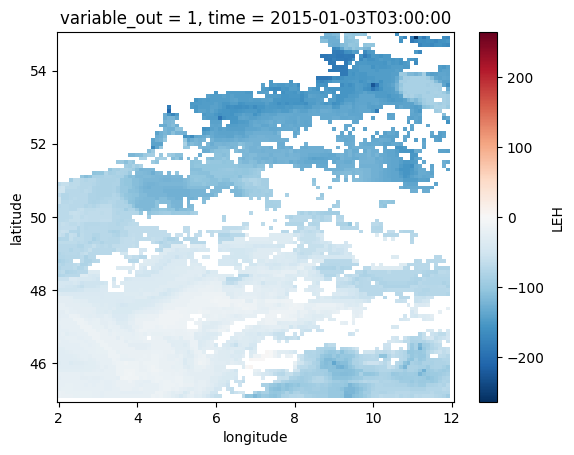

In [41]:
result1[100,:,:,1].plot() 

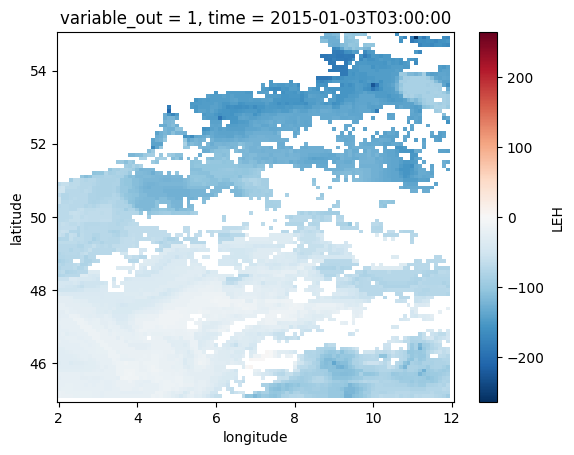

In [44]:
result1[100,:,:,1].plot() 
## I read SSM geoTiff file in this run, so the longitude and latitude was not overlapped with other variables, 
## but I changed to resampled SSM netCDF file(I rerun the 2000 timesteps after this change), the result is normal now.

## export the result